我们使用AGNews dataset数据集，通过finetune GPT进行情感分类任务。

In [1]:
import os
import numpy as np
import csv
import mindspore
from mindspore.dataset import text, GeneratorDataset, transforms
from mindspore import nn

from mindnlp import load_dataset
from mindnlp.transformers import GPTTokenizer
from mindnlp.transformers import GPTForSequenceClassification

from mindnlp.engine import Trainer, Evaluator
from mindnlp.engine.callbacks import CheckpointCallback, BestModelCallback
from mindnlp.metrics import Accuracy

/root/miniconda3/envs/king/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The **AGNews dataset** is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity. 
The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).
The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

In [ ]:
URL = {
    "train": "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv",
    "test": "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv",
}

It has four classes:
- World 
- Sports 
- Business 
- Sci/Tech 

{
    "label": 3,
    "text": "New iPad released Just like every other September, this one is no different. Apple is planning to release a bigger, heavier, fatter iPad that..."
}

**Customizing Dataset**
mindspore.dataset provides the loading APIs for some common datasets and standard format datasets. GeneratorDataset can help to load dataset based on the logic inside these classes/functions.

In [2]:
class RandomAccessDataset:
    def __init__(self, filepath):
        self._data, self._label = self._load_data(filepath)

    def _load_data(self, filepath):
        data, labels = [], []
        with open(filepath, encoding="utf-8") as csv_file:
            csv_reader = csv.reader(csv_file)
            next(csv_reader)  # Skip the header row if present
            for row in csv_reader:
                label, title, description = row
                label = int(label) - 1  # Adjust label to 0-indexed
                text = " ".join((title, description))  # Concatenate title and description
                labels.append(label)
                data.append(text)
        return data, labels

    def __getitem__(self, index):
        return self._data[index], self._label[index]

    def __len__(self):
        return len(self._data)
    



**Data Splits**
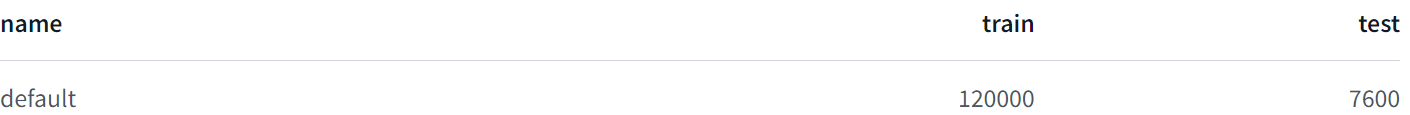

In [3]:
train_path = 'train.csv'
test_path = 'test.csv'
train_loader = RandomAccessDataset(train_path)
test_loader = RandomAccessDataset(test_path)
train_dataset = GeneratorDataset(source=train_loader, column_names=["text", "label"])
test_dataset = GeneratorDataset(source=test_loader, column_names=["text", "label"])

In [4]:
for data in train_dataset:
    print(data)
    break

[Tensor(shape=[], dtype=String, value= 'Fidelity slashes index-fund fees Fidelity Investments pays its mutual fund managers handsomely to do one thing: outsmart the stock market.'), Tensor(shape=[], dtype=Int64, value= 2)]


In [5]:
# tokenizer
gpt_tokenizer = GPTTokenizer.from_pretrained('./openai-gpt', from_pt=True)

# add sepcial token: <PAD>
special_tokens_dict = {
    "bos_token": "<bos>",
    "eos_token": "<eos>",
    "pad_token": "<pad>",
}
num_added_toks = gpt_tokenizer.add_special_tokens(special_tokens_dict)

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [6]:
# split train dataset into train and valid datasets
ds_train, ds_val = train_dataset.split([0.7, 0.3])

[WARNING] ME(1333:140490037392000,MainProcess):2024-01-20-13:26:51.927.260 [mindspore/dataset/engine/datasets.py:2480] Dataset is shuffled before split.


In [7]:
def process_dataset(dataset, tokenizer, max_seq_len=512, batch_size=16, shuffle=False):
    def tokenize(text):
        tokenized = tokenizer(text, truncation=True, max_length=max_seq_len)
        return tokenized[0], tokenized[1]

    if shuffle:
        dataset = dataset.shuffle(batch_size)

    # map dataset
    dataset = dataset.map(operations=[tokenize], input_columns="text", output_columns=['input_ids', 'attention_mask'])
    dataset = dataset.map(operations=transforms.TypeCast(mindspore.int32), input_columns="label", output_columns="labels")
    # batch dataset
    dataset = dataset.padded_batch(batch_size, pad_info={'input_ids': (None, tokenizer.pad_token_id),
                                                         'attention_mask': (None, 0)})

    return dataset

In [8]:
dataset_train = process_dataset(ds_train, gpt_tokenizer, shuffle=True)
dataset_val = process_dataset(ds_val, gpt_tokenizer)
dataset_test = process_dataset(test_dataset, gpt_tokenizer)


In [9]:
next(dataset_train.create_tuple_iterator())

[Tensor(shape=[16, 200], dtype=Int64, value=
 [[24845, 10530,  3106 ... 40480, 40480, 40480],
  [  284,   285, 19755 ... 40480, 40480, 40480],
  [10539,   285, 19755 ... 40480, 40480, 40480],
  ...
  [27817,  4579,  1834 ... 40480, 40480, 40480],
  [22703,   485,  3937 ... 40480, 40480, 40480],
  [ 3344,  5531,   240 ... 40480, 40480, 40480]]),
 Tensor(shape=[16, 200], dtype=Int64, value=
 [[1, 1, 1 ... 0, 0, 0],
  [1, 1, 1 ... 0, 0, 0],
  [1, 1, 1 ... 0, 0, 0],
  ...
  [1, 1, 1 ... 0, 0, 0],
  [1, 1, 1 ... 0, 0, 0],
  [1, 1, 1 ... 0, 0, 0]]),
 Tensor(shape=[16], dtype=Int32, value= [2, 2, 1, 3, 0, 0, 1, 3, 3, 3, 1, 0, 3, 2, 3, 1])]

In [10]:
# set bert config and define parameters for training
model = GPTForSequenceClassification.from_pretrained('openai-gpt', from_pt=True, num_labels=4)
model.config.pad_token_id = gpt_tokenizer.pad_token_id
model.resize_token_embeddings(model.config.vocab_size + 3)

optimizer = nn.Adam(model.trainable_params(), learning_rate=2e-5)

metric = Accuracy()

# define callbacks to save checkpoints
ckpoint_cb = CheckpointCallback(save_path='checkpoint', ckpt_name='gpt_agenews_finetune', epochs=1, keep_checkpoint_max=2)
best_model_cb = BestModelCallback(save_path='checkpoint', ckpt_name='gpt_agenews_finetune_best', auto_load=True)

trainer = Trainer(network=model, train_dataset=dataset_train,
                  eval_dataset=dataset_train, metrics=metric,
                  epochs=3, optimizer=optimizer, callbacks=[ckpoint_cb, best_model_cb],
                  jit=False)

The following parameters in models are missing parameter:
['score.weight']


In [11]:
trainer.run(tgt_columns="labels")


The train will start from the checkpoint saved in 'checkpoint'.


Epoch 0: 100%|██████████| 5250/5250 [15:59<00:00,  5.47it/s, loss=0.26279163]


Checkpoint: 'gpt_agenews_finetune_epoch_0.ckpt' has been saved in epoch: 0.


Evaluate: 100%|██████████| 5250/5250 [07:26<00:00, 11.75it/s]


Evaluate Score: {'Accuracy': 0.941475493755878}
---------------Best Model: 'gpt_agenews_finetune_best.ckpt' has been saved in epoch: 0.---------------


Epoch 1: 100%|██████████| 5250/5250 [16:51<00:00,  5.19it/s, loss=0.17396651]  


Checkpoint: 'gpt_agenews_finetune_epoch_1.ckpt' has been saved in epoch: 1.


Evaluate: 100%|██████████| 5250/5250 [06:36<00:00, 13.24it/s]


Evaluate Score: {'Accuracy': 0.9556899486898653}
---------------Best Model: 'gpt_agenews_finetune_best.ckpt' has been saved in epoch: 1.---------------


Epoch 2: 100%|██████████| 5250/5250 [15:53<00:00,  5.51it/s, loss=0.13529888]


The maximum number of stored checkpoints has been reached.
Checkpoint: 'gpt_agenews_finetune_epoch_2.ckpt' has been saved in epoch: 2.


Evaluate: 100%|██████████| 5250/5250 [06:29<00:00, 13.49it/s]


Evaluate Score: {'Accuracy': 0.9649519637138537}
---------------Best Model: 'gpt_agenews_finetune_best.ckpt' has been saved in epoch: 2.---------------
Loading best model from 'checkpoint' with '['Accuracy']': [0.9649519637138537]...
---------------The model is already load the best model from 'gpt_agenews_finetune_best.ckpt'.---------------


In [12]:
evaluator = Evaluator(network=model, eval_dataset=dataset_test, metrics=metric)
evaluator.run(tgt_columns="labels")

Evaluate: 100%|██████████| 475/475 [00:35<00:00, 13.41it/s]

Evaluate Score: {'Accuracy': 0.9327543097776023}
